In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import kagglehub


path = kagglehub.dataset_download("rhammell/ships-in-satellite-imagery")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Tymek\.cache\kagglehub\datasets\rhammell\ships-in-satellite-imagery\versions\9


<strong>From the datasets author:</strong>
The dataset is also distributed as a JSON formatted text file shipsnet.json. The loaded object contains data, label, scene_ids, and location lists.

In [3]:
file_path = path + '\shipsnet.json'

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Tymek\AppData\Local\Temp\ipykernel_15872\3462749704.py:1: SyntaxWarning: invalid escape sequence '\s'
  file_path = path + '\shipsnet.json'


In [4]:
with open(file_path,'r') as pt:
    df = json.load(pt)
    pt.close()

<strong>From the datasets author:</strong>
The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue.

Po transformacji płaskiej reprezetnacji danych, otrzymujemy 4000 zdjęć, 80x80, 3 kanały.

In [5]:
data = np.array(df['data']).astype('uint8')
img_length = 80
data = data.reshape(4000,3,img_length,img_length).transpose([0,2,3,1])

Warstwa Wyjściowa


In [6]:
labels = np.array(df['labels']).astype('uint8')
np.unique(labels)

array([0, 1], dtype=uint8)

Label = 0 oznacza "brak statku"
Label = 1 oznacza "statek"

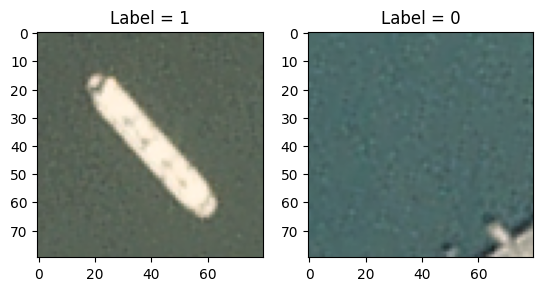

In [7]:
i = 0
fig,ax = plt.subplots(1,2)
ax[0].imshow(data[i])
ax[0].set_title(f"Label = {labels[i]}")
j = 1000
ax[1].imshow(data[j])
ax[1].set_title(f"Label = {labels[j]}")
plt.show()

In [8]:
import keras
from sklearn.model_selection import train_test_split
from keras import layers, models

C:\Users\Tymek\Documents\magisterskie\sem2\glebokie\Ships\Bay-Area-Ship-Detection-CNN\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Podział na zbiór treningowy i walidacyjny

In [9]:
X = data
y = labels

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

In [10]:
y_train.shape

(3200, 1)

### Model CNN

In [11]:
model = models.Sequential([
    layers.Input(shape=(80, 80, 3)),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(1,activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 78, 78, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 97344)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          97,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 97,793 (382.00 KB)

 Trainable params: 97,793 (382.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [14]:
from tensorflow.keras.callbacks import EarlyStopping

Aby uniknąć przeuczenia, używamy earlystopping

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,               
    restore_best_weights=True  
)

In [16]:
h = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=True,
    callbacks=[early_stop]    
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8066 - loss: 93.6720 - val_accuracy: 0.8800 - val_loss: 3.1905
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9153 - loss: 1.1315 - val_accuracy: 0.9287 - val_loss: 0.5441
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9447 - loss: 0.3601 - val_accuracy: 0.9237 - val_loss: 0.4412
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9588 - loss: 0.2357 - val_accuracy: 0.9087 - val_loss: 0.5240
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9716 - loss: 0.1232 - val_accuracy: 0.9413 - val_loss: 0.3744
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9778 - loss: 0.0716 - val_accuracy: 0.9388 - val_loss: 0.4389
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9872 - loss: 0.0380 - val_accuracy: 0.9388 - val_loss: 0.4628
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9925 - loss: 0.0240 - val_acc

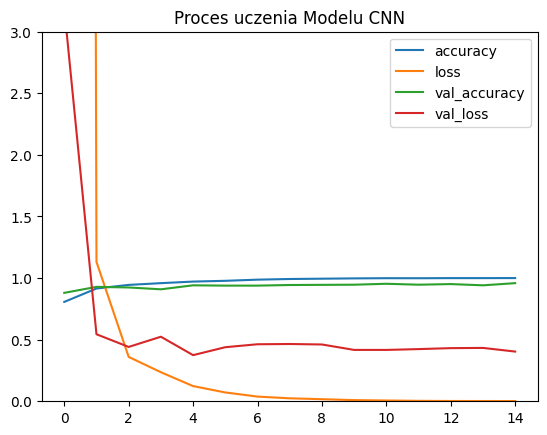

In [17]:
import pandas as pd

history = pd.DataFrame(h.history)
history.plot()
plt.title("Proces uczenia Modelu CNN")
plt.ylim(0,3)
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_probs = model.predict(X_val).flatten()

y_pred = (y_pred_probs > 0.5).astype("int32")

y_true = y_val.flatten()

cm = confusion_matrix(y_pred, y_true)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


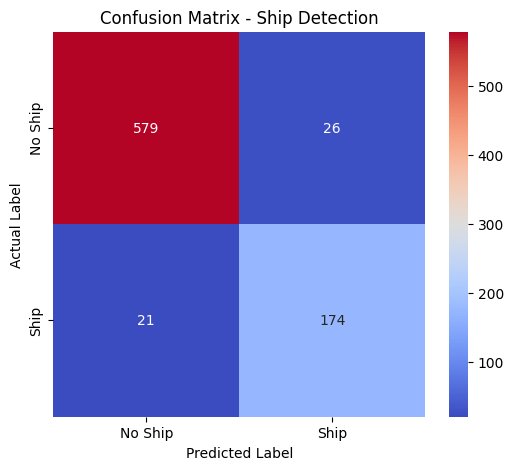

In [19]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=['No Ship', 'Ship'], 
            yticklabels=['No Ship', 'Ship'])

plt.title('Confusion Matrix - Ship Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

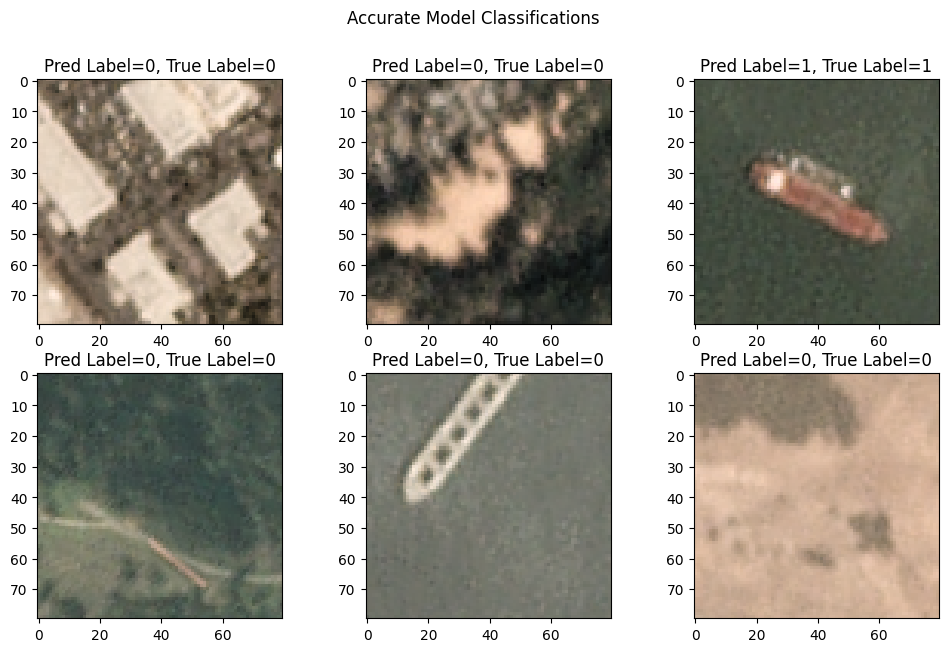

In [20]:
start = 0
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,figsize=(12,7))
fig.suptitle("Accurate Model Classifications")
for i,image in enumerate(X_val[start:start + rows*cols]):
    row = i // cols
    col = i % cols

    ax[row,col].imshow(image)
    ax[row,col].set_title(f'Pred Label={y_pred[start+i]}, True Label={y_true[start+i]}')

In [21]:
wrong_classification_indices = np.where(y_pred != y_true)[0]

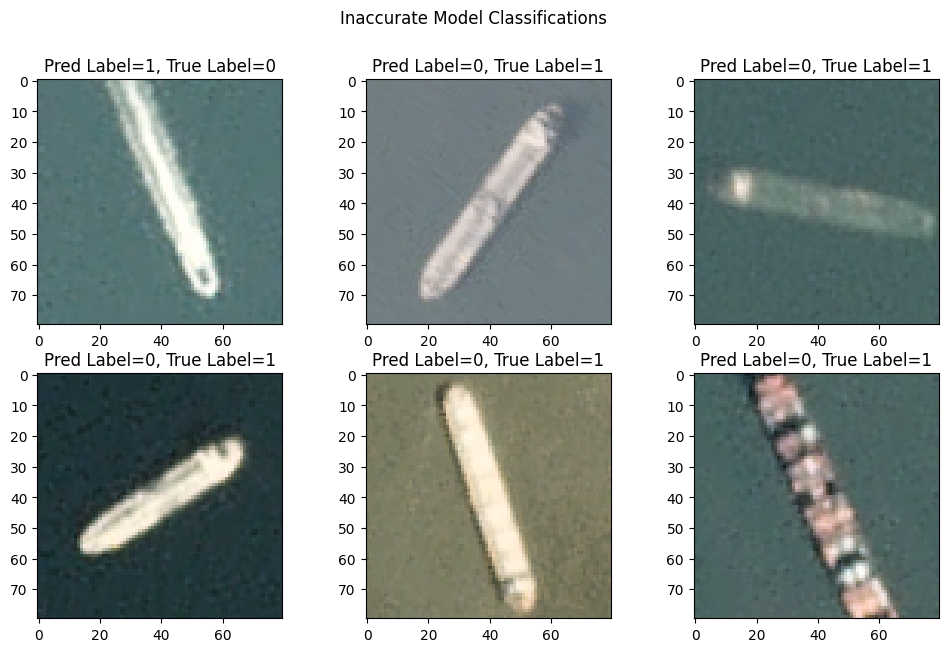

In [22]:
rows = 2
cols = 3
fig, ax = plt.subplots(rows,cols,figsize=(12,7))
fig.suptitle("Inaccurate Model Classifications")
for i in range(rows*cols):
    row = i // cols
    col = i % cols
    ax[row,col].imshow(X_val[wrong_classification_indices[i]])
    ax[row,col].set_title(f'Pred Label={y_pred[wrong_classification_indices[i]]}, True Label={y_true[wrong_classification_indices[i]]}')

### Augmentacja Danych

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def cloud_preprocessing(img):
   
    # Parametry zachmurzenia
    intensity = np.random.uniform(0.2, 0.5) # Losowa gęstość chmur
    blur_sigma = np.random.uniform(3, 7)
    
    noise = np.random.rand(80, 80)
    
    
    clouds = gaussian_filter(noise, sigma=blur_sigma)
    
    clouds = (clouds - clouds.min()) / (clouds.max() - clouds.min())
    
    clouds = np.where(clouds > (1 - intensity), clouds, 0)
    
    clouds_3d = np.stack([clouds]*3, axis=-1)
    
    img_with_clouds = img * (1 - clouds_3d) + clouds_3d
    img_with_clouds = img_with_clouds.astype('uint8')

    return np.clip(img_with_clouds, 0, 255)

img_index = 2
img_cloudy = cloud_preprocessing(X_val[img_index])

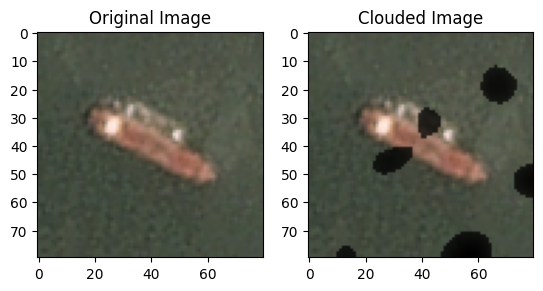

In [25]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(X_val[img_index])
ax[0].set_title("Original Image")
ax[1].imshow(img_cloudy)
ax[1].set_title("Clouded Image")
plt.show()

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Konfiguracja generatora
datagen = ImageDataGenerator(
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=cloud_preprocessing # Twoja funkcja chmur!
)

model_v2 = models.Sequential([
    layers.Input(shape=(80, 80, 3)),
    layers.Conv2D(16, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(1,activation='sigmoid')
])

model_v2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Uruchomienie treningu
# Zwróć uwagę, że X_train i y_train muszą być znormalizowane (0-1)
h = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val), # Walidacja pozostaje bez chmur
    epochs=30,
    verbose=1,
    callbacks=[early_stop]  
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.8388 - loss: 1.2729 - val_accuracy: 0.8813 - val_loss: 0.4074
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8434 - loss: 0.6457 - val_accuracy: 0.8662 - val_loss: 0.4044
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8512 - loss: 0.4819 - val_accuracy: 0.8675 - val_loss: 0.3764
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8453 - loss: 0.4904 - val_accuracy: 0.8813 - val_loss: 0.3041
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8584 - loss: 0.4030 - val_accuracy: 0.8450 - val_loss: 0.4257
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8666 - loss: 0.3739 - val_accuracy: 0.8838 - val_loss: 0.3513
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8575 - loss: 0.3833 - val_accuracy: 0.8763 - val_loss: 0.3920
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.8659 - loss: 0.3719 - 

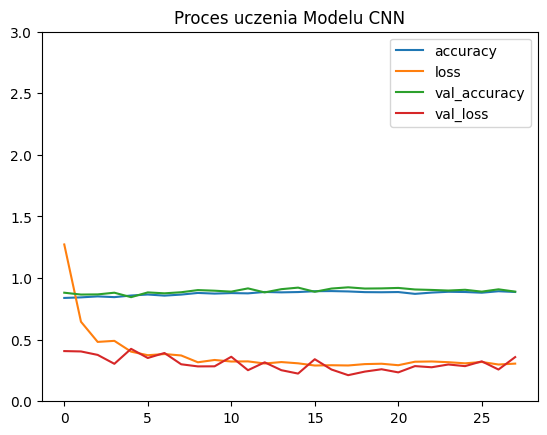

In [27]:
import pandas as pd

history_2 = pd.DataFrame(h.history)
history_2.plot()
plt.title("Proces uczenia Modelu CNN")
plt.ylim(0,3)
plt.show()

### Deep Model CNN

Pomimo bardzo wysokiej jakości klasyfikacji przez model bazowy, rozwinięto go o dodatkowe warstwy.

Celem było sprawdzenie czy można osiągnąć jeszcze większą dokładność, kosztem wielkości modelu i czasu treningu.

In [ ]:
model_v3 = models.Sequential([
    layers.Input(shape=(80, 80, 3)),
    
    
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_v3.summary()

In [ ]:
model_v3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
# h = model_v3.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=30,
#     batch_size=32,
#     verbose=True,
#     callbacks=[early_stop]    
# )